In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn import svm 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve, multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import feature_selection #import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow import keras

In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_test_fixed_2.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_train_fixed_2.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_val_fixed_2.csv')).drop(["Unnamed: 0"], axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "INC_MGMT_ORG_ABBREV", "EVACUATION_IN_PROGRESS", 
              "Incident_region", "NUM_REPORTS", "DAYS_BURING", 'Combined_Text']
predictors_to_be_scaled = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES","NUM_REPORTS", "DAYS_BURING"]
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

# Prepare the Data

In [5]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    #word_list = " ".join(word_list)
    return word_list

In [6]:
dfs = [train_data, val_data, test_data]
for df in dfs:
    cleaned_combined_text = []
    for text in df['Combined_Text']:
        cleaned_text = remove_quote_marks(text)
        cleaned_combined_text.append(cleaned_text)
    df['Combined_Text'] = cleaned_combined_text

In [7]:
Xtrain = train_data['Combined_Text']; ytrain = train_data[targets]
Xval = val_data['Combined_Text']; yval = val_data[targets]
Xtest = test_data['Combined_Text']; ytest = test_data[targets]

In [8]:
len(ytrain)

18596

In [9]:
st.mode([len(text) for text in Xtrain.tolist()])

ModeResult(mode=array([4]), count=array([1097]))

## Word2vec Model

In [10]:
lst_corpus = Xtrain

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=2, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=2, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

In [11]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=100,   
            window=5, min_count=3, sg=1)

In [12]:
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
## create sequence
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=30, padding="post", truncating="post")

In [13]:
lst_corpus = Xtest
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=30,
             padding="post", truncating="post")

corpus = Xval

## create list of n-grams
lst_corpus = Xval
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_val = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=30,
             padding="post", truncating="post")

In [14]:
len(X_train)

18596

# One-vs-rest

# LSTM NN

In [15]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: 

<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: 

<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings[idx] =  nlp[word]
<ipython-input-15-9112dbec5449>:6: DeprecationWarning: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
positive_weights = {}
negative_weights = {}
for c in targets:
    positive_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[c]==1))
    negative_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[c]==0))
#print(positive_weights)
#print(negative_weights)

In [17]:
def loss_fn(y_true,y_pred):
    loss = 0
    for t in targets:
        loss -= (positive_weights[t]*y_true[targets.index(t)]*K.log(y_pred[targets.index(t)]) + negative_weights[t]*(1-y_true[targets.index(t)])*K.log(1-y_pred[targets.index(t)]))
    return loss

In [18]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation='relu')(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(30,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=30, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=30)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(17, activation='sigmoid')(x)
## compile
lr = 1e-3
# First we need to define the optimizer to be used. We use Adam here with default hyper-parameters
optim = keras.optimizers.Adam(learning_rate=lr)
model = models.Model(x_in, y_out)
model.compile(loss=loss_fn,#'categorical_crossentropy',
              optimizer=optim, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      6518400     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 30)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 30)      930         permute[0][0]                    
______________________________________________________________________________________________

In [25]:
def build_simple_lstm(history_window, num_features,num_neurons):
    initializer = keras.initializers.GlorotNormal()
    
    input_layer = layers.Input(shape=(history_window,))
    ## embedding
    embedding_layer = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=100, trainable=False)(input_layer)
    
    rnn_layer = keras.layers.LSTM(num_neurons, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(0.01))(embedding_layer)
    dense_layer_0 = layers.Dense(num_neurons, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01))(rnn_layer)
    dense_layer_1 = layers.Dense(num_neurons, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01))(dense_layer_0)
    dense_layer_2 = layers.Dense(num_neurons, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01))(dense_layer_1)
    output = keras.layers.Dense(17, activation='softmax')(dense_layer_2)

    LSTM_model = keras.Model(input_layer, output)
    
    return LSTM_model
LSTM_model = build_simple_lstm(history_window=30, num_features=1, num_neurons=30)
LSTM_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 300)           6518400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                39720     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 17)                527 

In [26]:
mini_batch = 256
num_epochs = 20
lr = 1e-4
# First we need to define the optimizer to be used. We use Adam here with default hyper-parameters
optim = keras.optimizers.Adam(learning_rate=lr)

# then, we need to compile the model: this configures the model for training
LSTM_model.compile(loss=loss_fn,#'categorical_crossentropy',
              optimizer=optim, metrics=['accuracy'])
model=LSTM_model

In [27]:
training = model.fit(x=X_train, y=ytrain.astype(float), batch_size=mini_batch, 
                    epochs=num_epochs, shuffle=True, verbose=0, validation_data = (X_val, yval.astype(float))) 
                     #validation_split=0.3)

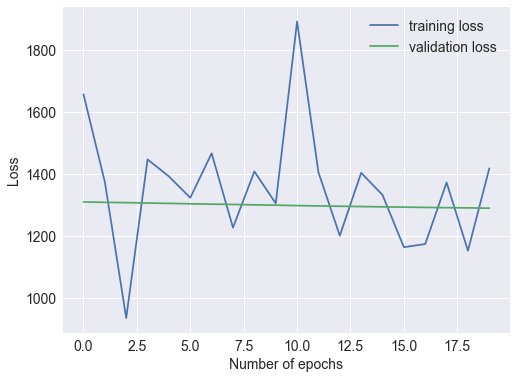

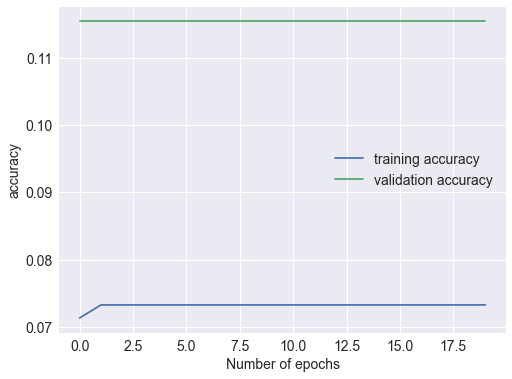

In [28]:
# plot loss and accuracy
plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['loss'], label='training loss')
plt.plot(range(num_epochs), training.history['val_loss'], label='validation loss')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('Loss', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)
plt.show()

plt.figure(figsize=(8, 6))
FONT=14
plt.plot(range(num_epochs), training.history['accuracy'], label='training accuracy')
plt.plot(range(num_epochs), training.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of epochs', fontsize=FONT)
plt.ylabel('accuracy', fontsize=FONT)
plt.legend(fontsize=FONT)
plt.tick_params(axis='both', which='major', labelsize=FONT)

plt.show()

Accuracy: 0.535
Detail:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       529
           2       0.00      0.00      0.00       155
           3       0.00      0.00      0.00       120
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       111
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00        40
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00       201
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00       700
          15       0.00      0.00      0.00        56
          16       0.00      0.00      0.00       168

  

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


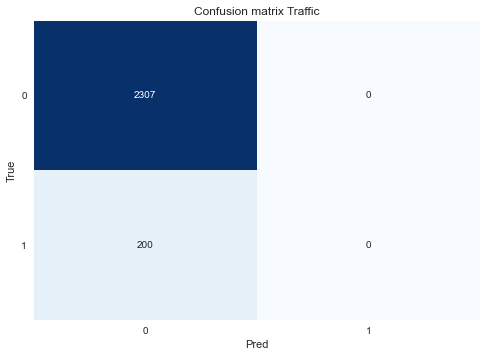

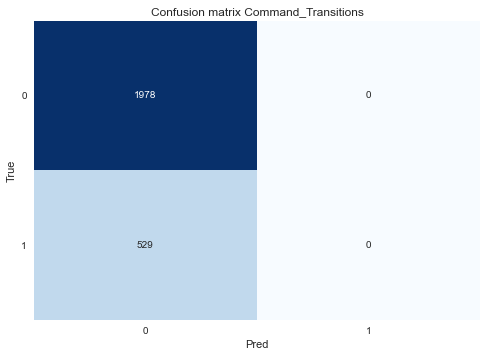

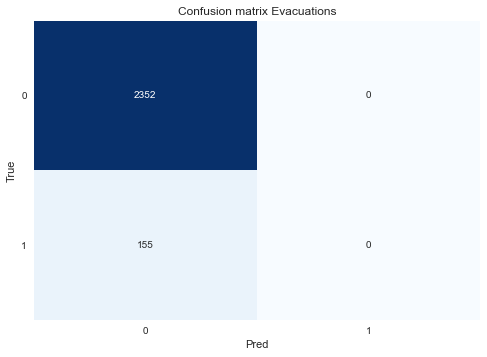

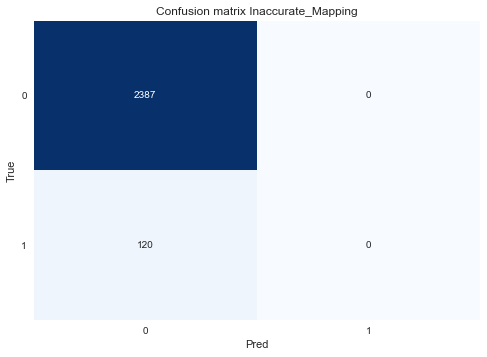

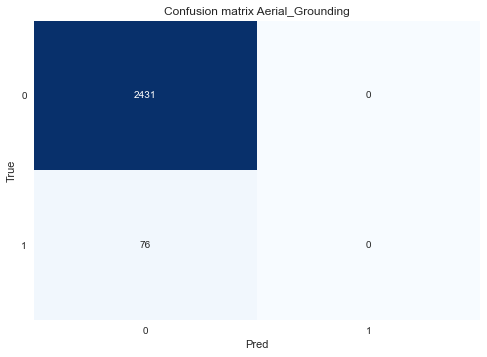

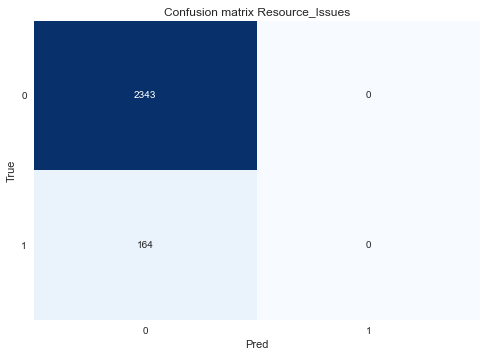

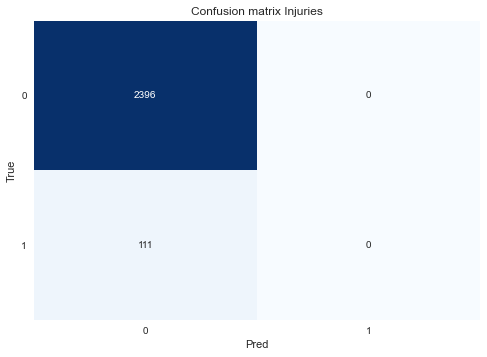

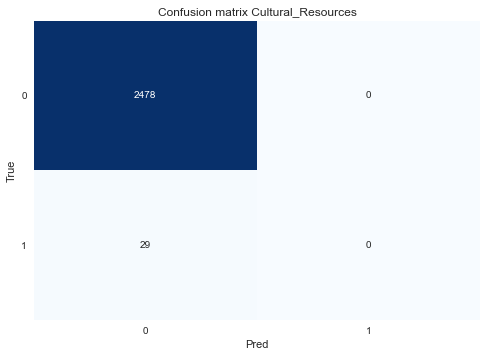

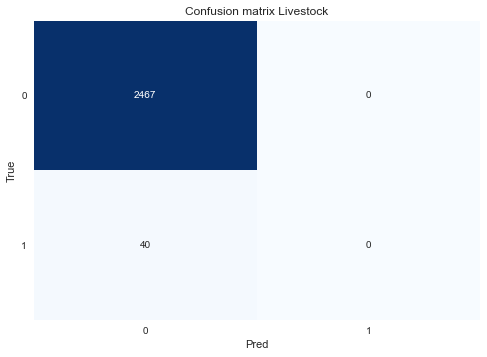

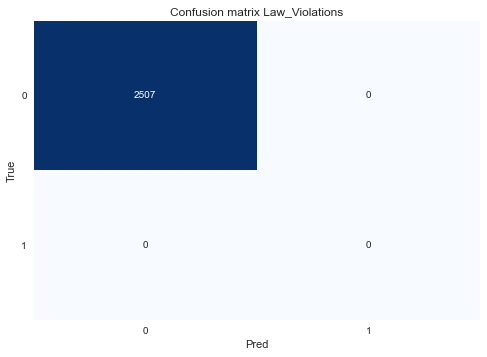

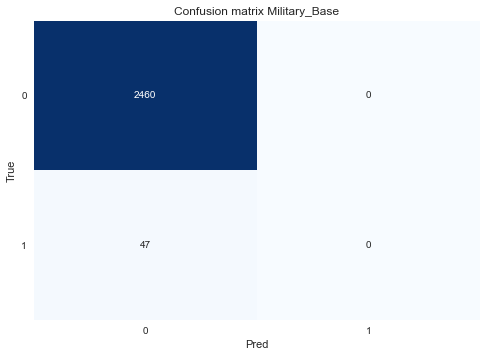

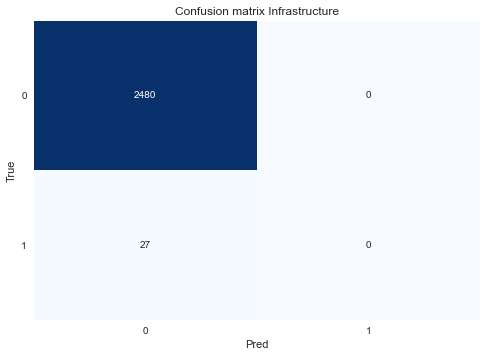

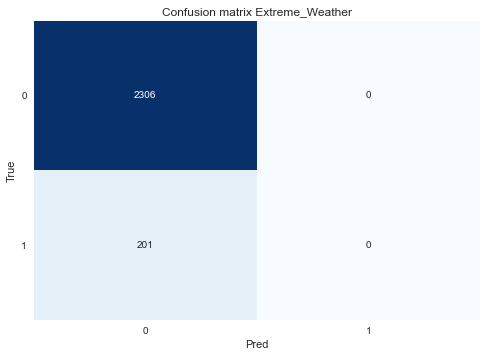

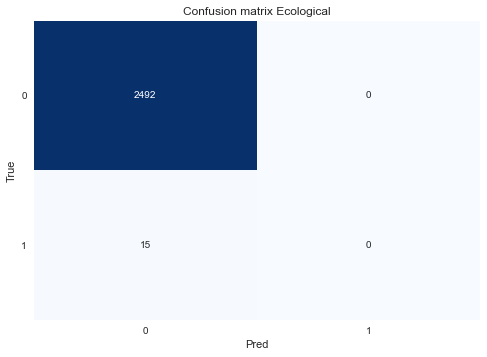

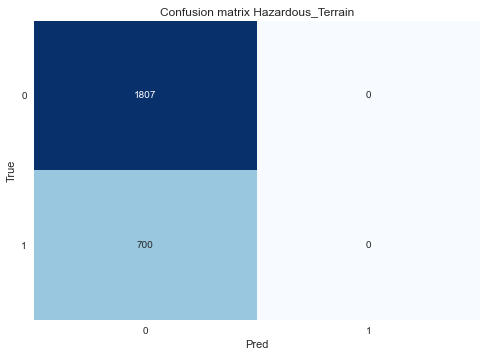

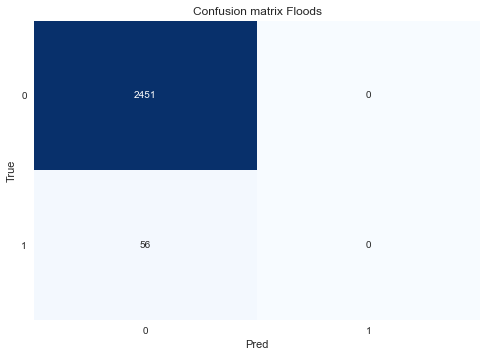

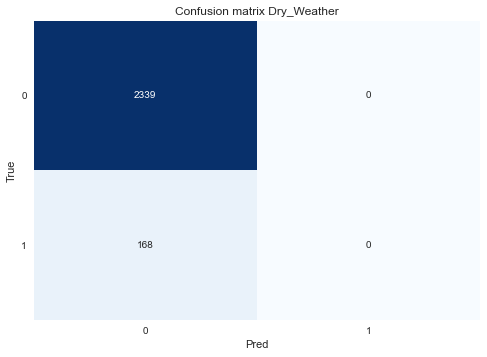

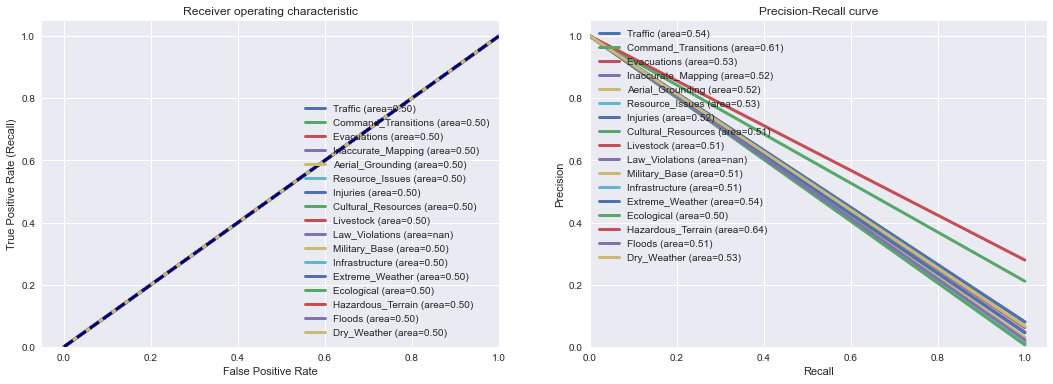

In [29]:
## test
predicted_raw = model.predict(X_test)
predicted = np.around(predicted_raw)
y_test_array = ytest.to_numpy()
## Accuracy, Precision, Recall
accuracy = accuracy_score(ytest, predicted)
#auc_score = roc_auc_score(ytest, predicted, 
#                            multi_class="ovr")
print("Accuracy:",  round(accuracy,3))
#print("Auc:", round(auc_score,3))
print("Detail:")
print(classification_report(ytest, predicted,zero_division=0))
    
## Plot confusion matrix

ml_cm = multilabel_confusion_matrix(ytest.to_numpy(), predicted)
i=0
for cm in ml_cm:
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
    plt.yticks(rotation=0)
    i+=1
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
for i in range(len(targets)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(targets[i], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(targets)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(targets[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [30]:
predicted_raw

array([[0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221],
       [0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221],
       [0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221],
       ...,
       [0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221],
       [0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221],
       [0.06069002, 0.06273557, 0.05951053, ..., 0.06349127, 0.05642642,
        0.06075221]], dtype=float32)

In [28]:
predicted

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
X_test

array([[  20,   18, 1361, ...,    0,    0,    0],
       [   3, 1714, 4375, ...,    0,    0,    0],
       [  85, 1211,  797, ...,    0,    0,    0],
       ...,
       [ 106,   26,  563, ...,    0,    0,    0],
       [  69,  130,  691, ...,    0,    0,    0],
       [ 540,   86,  146, ...,    0,    0,    0]])